### Libraries

In [1]:
import contextily as cx
from ipywidgets import interact
from math import floor
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from pyrsgis import raster
from pyrsgis.ml import imageChipsFromArray
import random
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf

### Loading the multispectral image

In [2]:
# file names
feature_file = './BrokenHill_Landsat9.tif'

# read the image
dsFeatures, arrFeatures = raster.read(feature_file, bands='all')
arrFeatures = arrFeatures.astype(float)
# arrFeatures = np.float16(arrFeatures)

# dsFeatures.__dict__

min_x = dsFeatures.bbox[0][0]
max_x = dsFeatures.bbox[1][0]
min_y = dsFeatures.bbox[0][1]
max_y = dsFeatures.bbox[1][1]

extent = [min_x, max_x, min_y, max_y]

### Visualizing spectral bands

In [3]:
def plot_array_stretched(array, label, n):
    fig, ax = plt.subplots(figsize=(10, 10))
    v_mean = np.array(np.nanmean(array))
    v_std = np.array(np.nanstd(array))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
    plt.yticks(rotation=90, va='center')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
    cb = ax.imshow(array, cmap='Greys_r', extent=extent, vmin=v_mean-(n*v_std), vmax=v_mean+(n*v_std))
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    plt.colorbar(cb, orientation='horizontal', label=label, cax=cax)
    plt.grid(False)
    plt.show()

def plot_array(array, label):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
    plt.yticks(rotation=90, va='center')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
    cb = ax.imshow(array, cmap='Greys_r', extent=extent)
    divider = make_axes_locatable(ax)
    cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
    fig.add_axes(cax)
    plt.colorbar(cb, orientation='horizontal', label=label, cax=cax)
    plt.grid(False)
    plt.show()

@interact(band=range(1, arrFeatures.shape[0]+1))
def show_dist(band):
    plot_array_stretched(arrFeatures[band-1, :, :], f'Band {band}', 3)

interactive(children=(Dropdown(description='band', options=(1, 2, 3, 4, 5, 6, 7), value=1), Output()), _dom_cl…

### Generating chips

In [4]:
# normalize the image and generate chips
arrFeatures_fuzzy = np.zeros(arrFeatures.shape)

for i in range(arrFeatures.shape[0]):
    bandMin = arrFeatures[i, :, :].min()
    bandMax = arrFeatures[i, :, :].max()
    bandRange = bandMax-bandMin
    for j in range(arrFeatures.shape[1]):
        for k in range(arrFeatures.shape[2]):
            arrFeatures_fuzzy[i, j, k] = (arrFeatures[i, j, k]-bandMin)/bandRange

# create chips using pyrsgis
features_chips = imageChipsFromArray(arrFeatures_fuzzy, x_size=7, y_size=7)

### Loading the training dataset (manual)

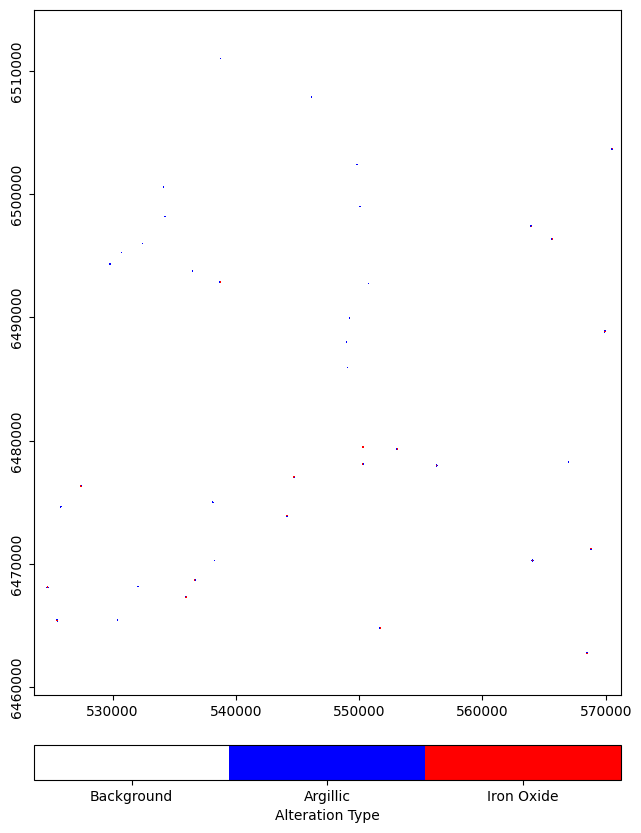

In [5]:
positiveLabel_file = './BrokenHill_Landsat8_Manual_CombinedTraining.tif'
# read and reshape the label file
dsPositiveLabels, arrPositiveLabels = raster.read(positiveLabel_file)
n_class_pos = len(np.unique(arrPositiveLabels))

fig, ax = plt.subplots(figsize=(10, 10))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = mpl.colors.ListedColormap(['white', 'blue', 'red'])
image = plt.imshow(arrPositiveLabels, cmap=cmap, extent=extent)
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
cbar = plt.colorbar(image, orientation='horizontal', label='Alteration Type', cax=cax)
tick_locs = (np.arange(n_class_pos) + 0.5)*(n_class_pos-1)/n_class_pos
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(['Background', 'Argillic', 'Iron Oxide'])
plt.grid(False)

### Generating random samples

In [6]:
# generate random samples
nonZero_count = np.count_nonzero(arrPositiveLabels)
index = np.transpose(np.where(arrPositiveLabels==0))
index = index.astype(int)
randomIndex = random.sample(range(index.shape[0]), int(nonZero_count/(n_class_pos-1)))
arrNegativeLabels = np.zeros(arrPositiveLabels.shape)

for i in range(len(randomIndex)):
    arrNegativeLabels[index[randomIndex[i], 0], index[randomIndex[i], 1]] = n_class_pos # max value of labels plus one which equals n_class
    
arrPositiveLabels_flat = arrPositiveLabels.flatten()
arrNegativeLabels_flat = arrNegativeLabels.flatten()
# separate and balance the classes
positiveFeatures = features_chips[arrPositiveLabels_flat!=0]
positiveLabels = arrPositiveLabels_flat[arrPositiveLabels_flat!=0]
negativeFeatures = features_chips[arrNegativeLabels_flat==n_class_pos]
negativeLabels = arrNegativeLabels_flat[arrNegativeLabels_flat==n_class_pos]
# combine the balanced features
features = np.concatenate((positiveFeatures, negativeFeatures), axis=0)
labels = np.concatenate((positiveLabels, negativeLabels), axis=0)

### Splitting features and labels into training and test datasets

In [7]:
# define a function to split features and labels
def train_test_split(features, labels, trainProp=0.7):
    dataSize = features.shape[0]
    sliceIndex = int(dataSize*trainProp)
    randIndex = np.arange(dataSize)
    random.shuffle(randIndex)
    train_x = features[[randIndex[:sliceIndex]], :, :, :][0]
    test_x = features[[randIndex[sliceIndex:]], :, :, :][0]
    train_y = labels[randIndex[:sliceIndex]]
    test_y = labels[randIndex[sliceIndex:]]
    return(train_x, train_y, test_x, test_y)

# call the function to split the dataset
train_x, train_y, test_x, test_y = train_test_split(features, labels)

### Training the model

In [8]:
# create the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size=1, padding='valid', activation='relu', input_shape=(train_x.shape[1], train_x.shape[2], train_x.shape[3])))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Conv2D(48, kernel_size=1, padding='valid', activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(4, activation='softmax'))

# print(model.summary())

# run the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.fit(train_x, train_y, epochs=40)
# predict for the test dataset
yTestPredicted = model.predict(test_x)
# calculate and display error metrics
yTestPredicted_ = yTestPredicted.argmax(axis=1)

cMatrix = confusion_matrix(test_y, yTestPredicted_)
pScore = precision_score(test_y, yTestPredicted_, average='micro')
rScore = recall_score(test_y, yTestPredicted_, average='micro')
fscore = f1_score(test_y, yTestPredicted_, average='micro')

print("Confusion matrix:\n", cMatrix)
print("\nP-Score: %.3f, R-Score: %.3f, F-Score: %.3f" % (pScore, rScore, fscore))

Epoch 1/40
33/33 [==============================] - 1s 4ms/step - loss: 1.1342 - accuracy: 0.3933
Epoch 2/40
33/33 [==============================] - 0s 4ms/step - loss: 1.0306 - accuracy: 0.4590
Epoch 3/40
33/33 [==============================] - 0s 4ms/step - loss: 0.9327 - accuracy: 0.5743
Epoch 4/40
33/33 [==============================] - 0s 4ms/step - loss: 0.8365 - accuracy: 0.6343
Epoch 5/40
33/33 [==============================] - 0s 4ms/step - loss: 0.7897 - accuracy: 0.6762
Epoch 6/40
33/33 [==============================] - 0s 4ms/step - loss: 0.7260 - accuracy: 0.7067
Epoch 7/40
33/33 [==============================] - 0s 4ms/step - loss: 0.6820 - accuracy: 0.7248
Epoch 8/40
33/33 [==============================] - 0s 4ms/step - loss: 0.6821 - accuracy: 0.7400
Epoch 9/40
33/33 [==============================] - 0s 4ms/step - loss: 0.6032 - accuracy: 0.7819
Epoch 10/40
33/33 [==============================] - 0s 4ms/step - loss: 0.5439 - accuracy: 0.8162
Epoch 11/40
33/33 [

### Mapping alteration zones

91947/91947 [==============================] - 181s 2ms/step


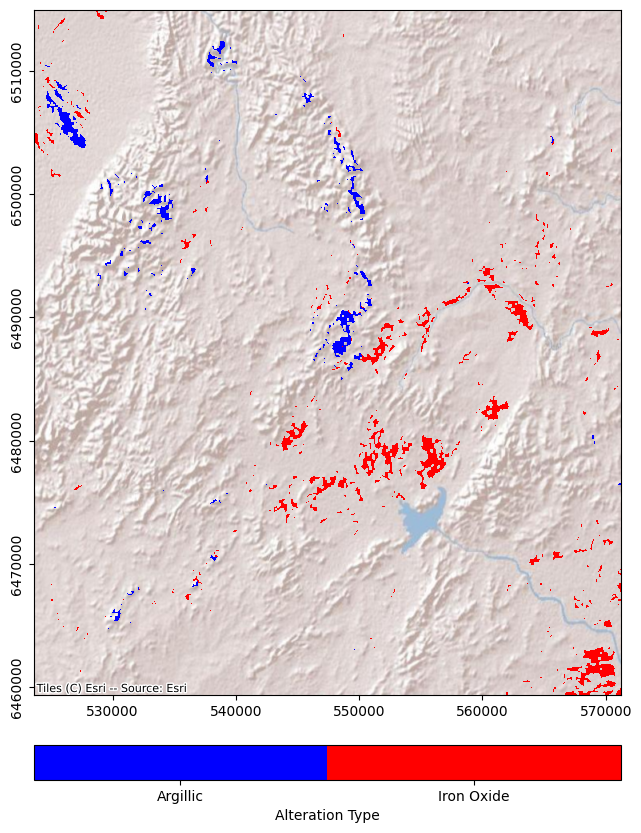

In [9]:
# # load and normalize a new multispectral image
# dsPred, arrPred = raster.read('./BrokenHill_Landsat8.tif')
# arrPred = arrPred.astype(float)
# # arrPred = np.float16(arrPred)
# arrPred_fuzzy = np.zeros(arrPred.shape)

# for i in range(arrPred.shape[0]):
#     bandMin = arrPred[i, :, :].min()
#     bandMax = arrPred[i, :, :].max()
#     bandRange = bandMax-bandMin
#     for j in range(arrPred.shape[1]):
#         for k in range(arrPred.shape[2]):
#             arrPred_fuzzy[i, j, k] = (arrPred[i, j, k]-bandMin)/bandRange

# # generate image chips from the array
# pred_features_chips = imageChipsFromArray(arrPred_fuzzy, x_size=7, y_size=7)

pred_features_chips = features_chips
dsPred = dsFeatures

# predict and export the probability raster
pred = model.predict(pred_features_chips)
pred_array = np.reshape(pred.argmax(axis=1), (dsPred.RasterYSize, dsPred.RasterXSize))

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)
cx.add_basemap(ax, crs='EPSG:32754', source=cx.providers.Esri.WorldShadedRelief)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = mpl.colors.ListedColormap(['blue', 'red'])

pred_array_copy = pred_array.copy()
pred_array_copy = pred_array_copy.astype('float')
pred_array_copy[pred_array_copy==3] = float('nan')
image = plt.imshow(pred_array_copy, cmap=cmap, extent=extent)

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
cbar = plt.colorbar(image, orientation='horizontal', label='Alteration Type', cax=cax)
tick_locs = (np.arange(n_class_pos-1) + 2.5)*(n_class_pos-2)/(n_class_pos-1)
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(['Argillic', 'Iron Oxide'])
plt.grid(False)

# outFile = './BrokenHill_Landsat8_Manual_CNN_AlterationMap.tif'
# raster.export(pred_array, dsPred, filename=outFile, dtype='float')

### Loading the training dataset (PCA)

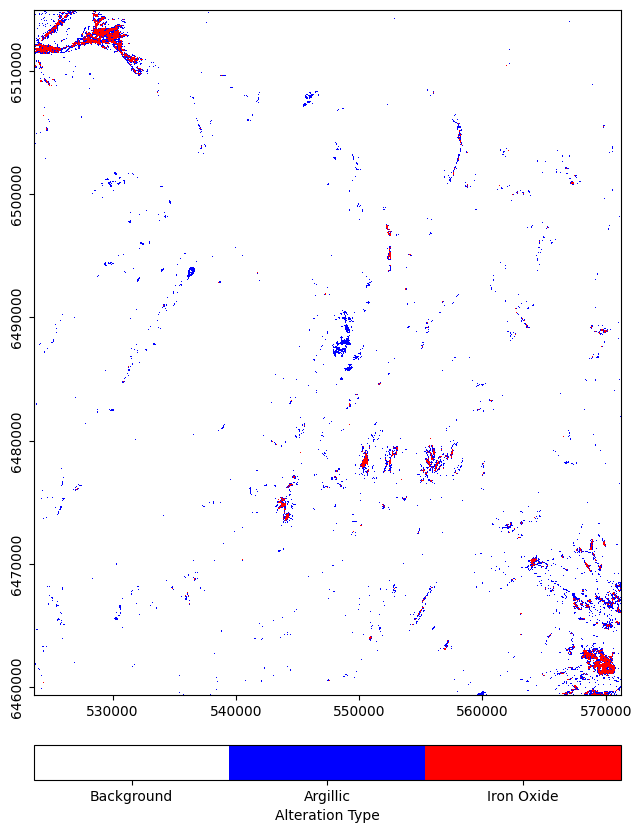

In [10]:
positiveLabel_file = './BrokenHill_Landsat8_PCA_CombinedTraining.tif'
# read and reshape the label file
dsPositiveLabels, arrPositiveLabels = raster.read(positiveLabel_file)
n_class_pos = len(np.unique(arrPositiveLabels))

fig, ax = plt.subplots(figsize=(10, 10))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = mpl.colors.ListedColormap(['white', 'blue', 'red'])
image = plt.imshow(arrPositiveLabels, cmap=cmap, extent=extent)
divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
cbar = plt.colorbar(image, orientation='horizontal', label='Alteration Type', cax=cax)
tick_locs = (np.arange(n_class_pos) + 0.5)*(n_class_pos-1)/n_class_pos
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(['Background', 'Argillic', 'Iron Oxide'])
plt.grid(False)

### Generating random samples

In [11]:
# generate random samples
nonZero_count = np.count_nonzero(arrPositiveLabels)
index = np.transpose(np.where(arrPositiveLabels==0))
index = index.astype(int)
randomIndex = random.sample(range(index.shape[0]), int(nonZero_count/(n_class_pos-1)))
arrNegativeLabels = np.zeros(arrPositiveLabels.shape)

for i in range(len(randomIndex)):
    arrNegativeLabels[index[randomIndex[i], 0], index[randomIndex[i], 1]] = n_class_pos # max value of labels plus one which equals n_class
    
arrPositiveLabels_flat = arrPositiveLabels.flatten()
arrNegativeLabels_flat = arrNegativeLabels.flatten()
# separate and balance the classes
positiveFeatures = features_chips[arrPositiveLabels_flat!=0]
positiveLabels = arrPositiveLabels_flat[arrPositiveLabels_flat!=0]
negativeFeatures = features_chips[arrNegativeLabels_flat==n_class_pos]
negativeLabels = arrNegativeLabels_flat[arrNegativeLabels_flat==n_class_pos]
# combine the balanced features
features = np.concatenate((positiveFeatures, negativeFeatures), axis=0)
labels = np.concatenate((positiveLabels, negativeLabels), axis=0)

### Splitting features and labels into training and test datasets

In [12]:
# define a function to split features and labels
def train_test_split(features, labels, trainProp=0.7):
    dataSize = features.shape[0]
    sliceIndex = int(dataSize*trainProp)
    randIndex = np.arange(dataSize)
    random.shuffle(randIndex)
    train_x = features[[randIndex[:sliceIndex]], :, :, :][0]
    test_x = features[[randIndex[sliceIndex:]], :, :, :][0]
    train_y = labels[randIndex[:sliceIndex]]
    test_y = labels[randIndex[sliceIndex:]]
    return(train_x, train_y, test_x, test_y)

# call the function to split the dataset
train_x, train_y, test_x, test_y = train_test_split(features, labels)

### Training the model

In [13]:
# create the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size=1, padding='valid', activation='relu', input_shape=(train_x.shape[1], train_x.shape[2], train_x.shape[3])))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Conv2D(48, kernel_size=1, padding='valid', activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(4, activation='softmax'))

# print(model.summary())

# run the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.fit(train_x, train_y, epochs=40)
# predict for the test dataset
yTestPredicted = model.predict(test_x)
# calculate and display error metrics
yTestPredicted_ = yTestPredicted.argmax(axis=1)

cMatrix = confusion_matrix(test_y, yTestPredicted_)
pScore = precision_score(test_y, yTestPredicted_, average='micro')
rScore = recall_score(test_y, yTestPredicted_, average='micro')
fscore = f1_score(test_y, yTestPredicted_, average='micro')

print("Confusion matrix:\n", cMatrix)
print("\nP-Score: %.3f, R-Score: %.3f, F-Score: %.3f" % (pScore, rScore, fscore))

Epoch 1/40
2118/2118 [==============================] - 19s 8ms/step - loss: 0.6448 - accuracy: 0.7247
Epoch 2/40
2118/2118 [==============================] - 29s 14ms/step - loss: 0.4502 - accuracy: 0.8260
Epoch 3/40
2118/2118 [==============================] - 33s 15ms/step - loss: 0.4121 - accuracy: 0.8438
Epoch 4/40
2118/2118 [==============================] - 33s 15ms/step - loss: 0.3904 - accuracy: 0.8527
Epoch 5/40
2118/2118 [==============================] - 32s 15ms/step - loss: 0.3789 - accuracy: 0.8613
Epoch 6/40
2118/2118 [==============================] - 28s 13ms/step - loss: 0.3720 - accuracy: 0.8636
Epoch 7/40
2118/2118 [==============================] - 33s 16ms/step - loss: 0.3581 - accuracy: 0.8708
Epoch 8/40
2118/2118 [==============================] - 32s 15ms/step - loss: 0.3527 - accuracy: 0.8748
Epoch 9/40
2118/2118 [==============================] - 32s 15ms/step - loss: 0.3469 - accuracy: 0.8764
Epoch 10/40
2118/2118 [==============================] - 31s 15ms

### Mapping alteration zones

91947/91947 [==============================] - 240s 3ms/step


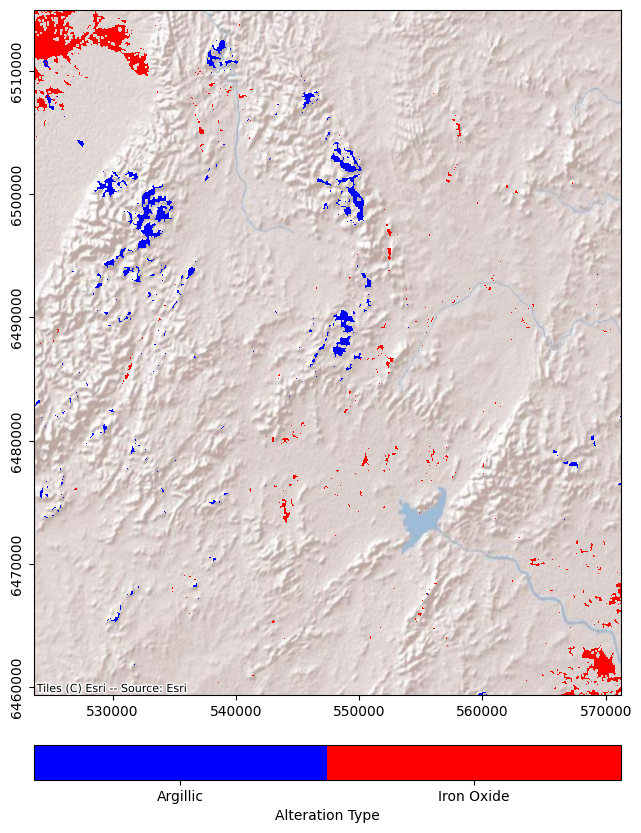

In [14]:
# # load and normalize a new multispectral image
# dsPred, arrPred = raster.read('./BrokenHill_Landsat8.tif')
# arrPred = arrPred.astype(float)
# # arrPred = np.float16(arrPred)
# arrPred_fuzzy = np.zeros(arrPred.shape)

# for i in range(arrPred.shape[0]):
#     bandMin = arrPred[i, :, :].min()
#     bandMax = arrPred[i, :, :].max()
#     bandRange = bandMax-bandMin
#     for j in range(arrPred.shape[1]):
#         for k in range(arrPred.shape[2]):
#             arrPred_fuzzy[i, j, k] = (arrPred[i, j, k]-bandMin)/bandRange

# # generate image chips from the array
# pred_features_chips = imageChipsFromArray(arrPred_fuzzy, x_size=7, y_size=7)

pred_features_chips = features_chips
dsPred = dsFeatures

# predict and export the probability raster
pred = model.predict(pred_features_chips)
pred_array = np.reshape(pred.argmax(axis=1), (dsPred.RasterYSize, dsPred.RasterXSize))

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xlim(min_x, max_x)
ax.set_ylim(min_y, max_y)
cx.add_basemap(ax, crs='EPSG:32754', source=cx.providers.Esri.WorldShadedRelief)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
plt.yticks(rotation=90, va='center')
ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
cmap = mpl.colors.ListedColormap(['blue', 'red'])

pred_array_copy = pred_array.copy()
pred_array_copy = pred_array_copy.astype('float')
pred_array_copy[pred_array_copy==3] = float('nan')
image = plt.imshow(pred_array_copy, cmap=cmap, extent=extent)

divider = make_axes_locatable(ax)
cax = divider.new_vertical(size='5%', pad=0.5, pack_start=True)
fig.add_axes(cax)
cbar = plt.colorbar(image, orientation='horizontal', label='Alteration Type', cax=cax)
tick_locs = (np.arange(n_class_pos-1) + 2.5)*(n_class_pos-2)/(n_class_pos-1)
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(['Argillic', 'Iron Oxide'])
plt.grid(False)

# outFile = './BrokenHill_Landsat8_PCA_CNN_AlterationMap.tif'
# raster.export(pred_array, dsPred, filename=outFile, dtype='float')